solvation shell =   4.57925
solvation shell =   4.499928571428572


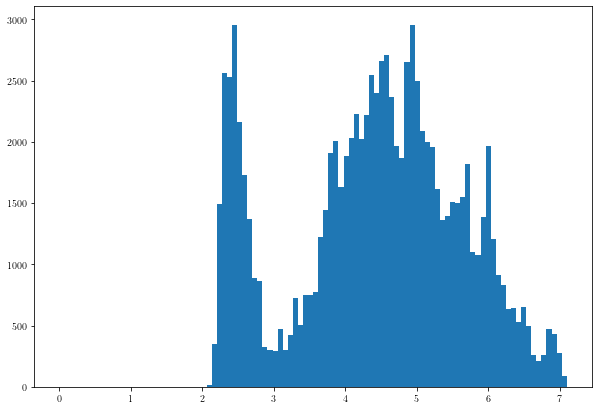

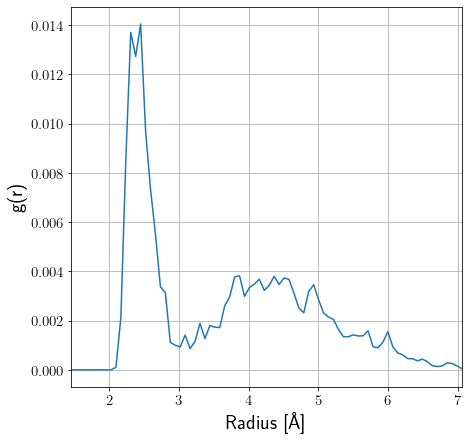

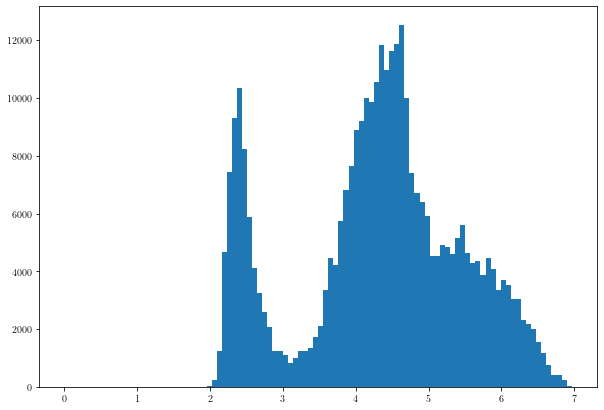

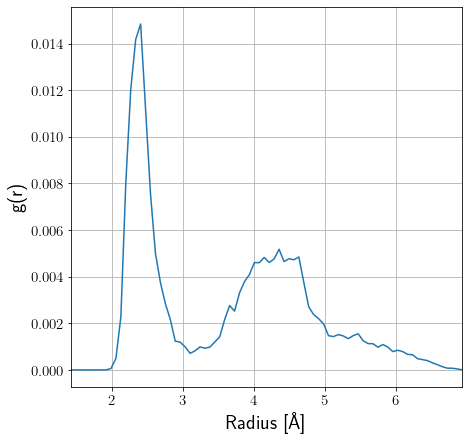

In [9]:
# Initialization
import numpy as np
import scipy as sp
from ase import Atoms
from ase.io.trajectory import Trajectory
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = True

# Importing the trajectory
traj = Trajectory('Data/Dynamics.traj')
traj_theirs = Trajectory('Na-aimd/NaCluster24.traj')

#Parameters
start_snap = 0
stop_snap = len(traj) 
distances = np.zeros([])
distance_sum = np.zeros(72)
cell_volume = traj[0].get_volume()
particle_density = cell_volume/len(traj[0]) 

for i in range(start_snap,stop_snap):
    atoms = traj[i]
    distances = np.append(distances,atoms.get_distances(72,atoms.get_atomic_numbers()==8,mic=True))
        
distance_sum *= (len(traj))**-1
distance_sum = np.sort(distance_sum)

fig,ax = plt.subplots(figsize=(10,7))

plt.hist(distances,bins = 100)
hist = np.histogram(distances,bins=100)

dr = hist[1][1]-hist[1][0]
r = hist[1][1:]-dr/2
dn_r = hist[0]/(stop_snap-start_snap) 

gPrime = dn_r*(4*np.pi*r**2*dr*particle_density)**-1
g = dn_r*(dr)**-1

r_1 = 3
r_2 = 8
minapprox = int((r_1-r[0])/dr) #Place to start searching for first minimum
minimum = np.argmin(gPrime[minapprox-r_2:minapprox+r_2])+minapprox-r_2
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(r[20:],gPrime[20:])

ax.set_xlabel(r"Radius [Å]",fontsize=20)
ax.set_ylabel(r"g(r)",fontsize=20)
ax.tick_params(axis = 'both', labelsize = 15)
ax.set_xlim([r[20],r[-1]])
ax.grid()
plt.savefig(f'Figures/RDF ours.pdf',bbox_inches='tight')
print("solvation shell =  ", sum(hist[0][:minimum])/(stop_snap-start_snap))


#Parameters
start_snap = 0
stop_snap = len(traj_theirs) 
distances = np.zeros([])
distance_sum = np.zeros(72)
cell_volume = traj_theirs[0].get_volume()
particle_density = cell_volume/len(traj_theirs[0]) 

for i in range(start_snap,stop_snap):
    atoms = traj_theirs[i]
    distances = np.append(distances,atoms.get_distances(72,atoms.get_atomic_numbers()==8,mic=True))
        
distance_sum *= (len(traj_theirs))**-1
distance_sum = np.sort(distance_sum)

fig,ax = plt.subplots(figsize=(10,7))

plt.hist(distances,bins = 100)
hist = np.histogram(distances,bins=100)

dr = hist[1][1]-hist[1][0]
r = hist[1][1:]-dr/2
dn_r = hist[0]/(stop_snap-start_snap) 

gPrime = dn_r*(4*np.pi*r**2*dr*particle_density)**-1
g = dn_r*(dr)**-1

r_1 = 3
r_2 = 8
minapprox = int((r_1-r[0])/dr) #Place to start searching for first minimum
minimum = np.argmin(gPrime[minapprox-r_2:minapprox+r_2])+minapprox-r_2
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(r[20:],gPrime[20:])

ax.set_xlabel(r"Radius [Å]",fontsize=20)
ax.set_ylabel(r"g(r)",fontsize=20)
ax.tick_params(axis = 'both', labelsize = 15)
ax.set_xlim([r[20],r[-1]])
ax.grid()
plt.savefig(f'Figures/RDF theirs.pdf',bbox_inches='tight')
print("solvation shell =  ", sum(hist[0][:minimum])/(stop_snap-start_snap))